In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import os
from scipy.spatial.transform import Rotation as R
import traceback
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

    

def angle_between_vectors(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'. """
    v1_u = v1 / np.linalg.norm(v1, axis=1)[:, np.newaxis]
    v2_u = v2 / np.linalg.norm(v2, axis=1)[:, np.newaxis]
    return np.arccos(np.clip(np.sum(v1_u * v2_u, axis=1), -1.0, 1.0))

def rotation_matrices_to_euler(Es_array, Ed_array):
    # Convert the rotation matrices into Euler angles
    euler_Es = R.from_matrix(Es_array).as_euler('XYZ')
    euler_Ed = R.from_matrix(Ed_array).as_euler('XYZ')
    euler_Es = euler_Es*180/np.pi
    euler_Ed = euler_Ed*180/np.pi

    # Adjust angles for ellipsoid symmetry: limit theta to [0, 180] degrees
    # Psi and Phi can remain within [-180, 180] due to full rotational symmetry about the axes

    return euler_Es, euler_Ed

def adjust_euler_angles(angles):
    try:
        first_angle = np.copy(angles[:, 0])
        third_angle = np.copy(angles[:, 2])
        second_angle = np.copy(angles[:, 1])
    
        
        #print('first')
        above_90 = first_angle > 90
        below_neg90 = first_angle < -90

        first_angle[above_90] -= 180
        first_angle[below_neg90] += 180

    
        above_90 = third_angle > 90
        below_neg90 = third_angle < -90

        third_angle[above_90] -= 180
        third_angle[below_neg90] += 180

    
        angles[:, 0] = first_angle
        angles[:, 2] = third_angle
        return(angles)
    except:
        return angles*np.nan
        #print(angles)
        

    
    
def plot_angle_diff(angular_diff_s,angular_diff_d,angular_diff, rbins, sim, feedback, hid, Reff):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6))  # Create three subplots for each Euler angle
    mask = angular_diff > 90
    angular_diff[mask] =  abs(angular_diff[mask] - 180)
    #print(angular_diff[mask])

    angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\Delta Z $'+u'\N{DEGREE SIGN}']
    colors = ['red', 'green', 'blue']
    diff_at_Reff = []

    for i, ax in enumerate(axs):
        ax.set_xlim([0, max(rbins)])

        yticks = np.linspace(0,90,4)
        ax.set_ylim([yticks[0], yticks[-1]])  # Adjust the y-limits if needed based on your data range
        ax.set_yticks(yticks)

        # Adjust the i-th Euler angle for symmetry or any other adjustments

        
        # Plot raw data
        ax.plot(rbins, angular_diff[:, i], label=f'Angular Distance', color=colors[i],linestyle='--')
        
        #plot smoothed angular_diff[:, i]
        angle_diff_smoothed = gaussian_filter(angular_diff[:, i], sigma=5)
        ax.plot(rbins, angle_diff_smoothed, label=f'Smoothed Angular Distance', color=colors[i])
        #print near Reff from angle_diff_smoothed
        diff = angle_diff_smoothed[np.argmin(np.abs(rbins-Reff))]
        print(f'{angle_names[i]} at Reff: {diff}')
        diff_at_Reff.append(diff)
        
        
        #ax.plot(rbins, angular_diff_s[:, i], label=f'Stellar', color=colors[i])
        
        #ax.plot(rbins, angular_diff_d[:, i], label=f'Dark Matter', color='black')
        '''
        # Apply Gaussian filter
        sigma = 5  # Standard deviation for Gaussian kernel
        smoothed_Es = gaussian_filter(euler_Es[:, i], sigma=sigma)
        smoothed_Ed = gaussian_filter(euler_Ed[:, i], sigma=sigma)
        
        
        interp_function_Es = interp1d(rbins, smoothed_Es, kind='cubic')
        interp_function_Ed = interp1d(rbins, smoothed_Ed, kind='cubic')
        Euler_s_smooth.append(interp_function_Es)
        Euler_d_smooth.append(interp_function_Ed)
        

        #print(interp_function_Es(Reff))
        # Plot smoothed data
        ax.plot(rbins, interp_function_Es(rbins), color=colors[i], linestyle='--')
        ax.plot(rbins, interp_function_Ed(rbins), label='Smoothed', color='black', linestyle='--')
        '''
        
        ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
        ax.grid(True)
        ax.set_xlabel('R [kpc]',fontsize=15)
        ax.set_ylabel(rf'{angle_names[i]}',fontsize = 15)
        ax.legend()

    #plt.tight_layout()
    plt.suptitle(f'Angular Differences between DM and Stellar: {sim}, Halo ID: {hid}')
    
    # Save the figure
    save_path = f'../../Figures/3DShapes/OrientationsXYZ/{sim}.{feedback}.{hid}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path,dpi = 100)
    plt.close()
    return diff_at_Reff


def plot_euler_angles(euler_Es, euler_Ed, rbins, sim, feedback, hid, Reff):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6))  # Create three subplots for each Euler angle

    angle_names = ['$\Phi$', '$\Theta$', '$\Psi$']
    colors = ['red', 'green', 'blue']  # Use different colors for each angle for better distinction
    euler_Es = adjust_euler_angles(euler_Es)
    euler_Ed = adjust_euler_angles(euler_Ed)
    Euler_s_smooth,Euler_d_smooth= [],[]
    
    for i, ax in enumerate(axs):
        ax.set_xlim([0, max(rbins)])
        yavg = np.average(euler_Es[:, i])
        std = np.max( (np.std(euler_Es[:, i])  ,np.std(euler_Ed[:, i])) )
        ax.set_ylim(yavg - 2*std,yavg + 2*std)
        #ax.set_ylim([-90, 90])  # Adjust the y-limits if needed based on your data range
        #ax.set_yticks(np.linspace(-90,90,7))

        # Adjust the i-th Euler angle for symmetry or any other adjustments

        
        # Plot raw data
        ax.plot(rbins, euler_Es[:, i], label=f'Stellar', color=colors[i])
        ax.plot(rbins, euler_Ed[:, i], label=f'Dark Matter', color='black')
        
        # Apply Gaussian filter
        sigma = 5  # Standard deviation for Gaussian kernel
        smoothed_Es = gaussian_filter(euler_Es[:, i], sigma=sigma)
        smoothed_Ed = gaussian_filter(euler_Ed[:, i], sigma=sigma)
        
        
        interp_function_Es = interp1d(rbins, smoothed_Es, kind='cubic')
        interp_function_Ed = interp1d(rbins, smoothed_Ed, kind='cubic')
        Euler_s_smooth.append(interp_function_Es)
        Euler_d_smooth.append(interp_function_Ed)
        

        #print(interp_function_Es(Reff))
        # Plot smoothed data
        ax.plot(rbins, interp_function_Es(rbins), color=colors[i], linestyle='--')
        ax.plot(rbins, interp_function_Ed(rbins), label='Smoothed', color='black', linestyle='--')

        ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
        ax.grid(True)
        ax.set_xlabel('R [kpc]',fontsize=15)
        ax.set_ylabel(rf'{angle_names[i]}',fontsize = 15)
        ax.legend()

    #plt.tight_layout()
    plt.suptitle(f'Euler Angles for Simulation: {sim}, Halo ID: {hid}')
    
    # Save the figure
    save_path = f'../../Figures/3DShapes/Orientations/{sim}.{feedback}.{hid}.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path,dpi = 100)
    #lt.close()
    return Euler_s_smooth,Euler_d_smooth






<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:140: SyntaxWarning: invalid escape sequence '\T'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:140: SyntaxWarning: invalid escape sequence '\P'
<>:140: SyntaxWarning: invalid escape sequence '\T'
<>:140: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_3453844/3298615976.py:72: SyntaxWarning: invalid escape sequence '\D'
  angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\Delta Z $'+u'\N{DEGREE SIGN}']
/tmp/ipykernel_3453844/3298615976.py:72: SyntaxWarning: invalid escape sequence '\D'
  angle_names = ['$\Delta X  $'+u'\N{DEGREE SIGN}', '$\Delta Y  $'+u'\N{DEGREE SIGN}', '$\D

In [23]:

def remove_degeneracy(rotation_matrices):
    """
    Removes the degeneracy in the rotation matrices for a rectangular prism.
    """
    # Extract the rotation angles around each axis
    angles = R.from_matrix(rotation_matrices).as_euler('xyz', degrees=True)
    
    # Normalize the angles to the range [-180, 180]
    angles = (angles + 180) % 360 - 180
    
    # Check if any angle is close to 180 degrees
    mask = np.abs(angles) > 90
    angles[mask] = 180 - angles[mask]
    
    # Create new rotation matrices from the modified angles
    modified_rotations = R.from_euler('xyz', angles, degrees=True)
    
    return modified_rotations.as_matrix()


def plot_orientation_angles(SimFilePath, feedback, reff_multi):
    diffs_at_Reff = []
    for i in range(len(SimFilePath)):
        SimInfo = pickle.load(open(SimFilePath[i], 'rb'))
        #mass_data = pickle.load(open(MassPath[i], 'rb'))
        #dataframe = pd.read_csv(HaloTypePath[i], sep='\s+')
        

        for sim in SimInfo:
            try:
                StShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'rb'))
                DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'rb'))
                Profiles = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.Profiles.pickle', 'rb'))
            except:
                print(f'Error loading {sim} {feedback[i]}')
                continue
            

            
            for hid in SimInfo[sim]['goodhalos']:
                key = (sim, str(hid))
                try:
                    rbins = StShapes[str(hid)]['rbins']
                    Es = np.array((StShapes[str(hid)]['Es']))
                    Ed = np.array((DMShapes[str(hid)]['Es']))
                    Reff = Profiles[str(hid)]['x000y000']['Reff'] * reff_multi
                    #angle_s = StShapes[str(hid)]['angle']
                    #angle_d = DMShapes[str(hid)]['angle']

                    if Es.shape == (3, 3):
                        continue
                    if Ed.shape == (3, 3):
                        continue

                                    
                    


                    
                    rotation_matrix = np.array([[1, 0, 0],
                                                [0, -1, 0],
                                                [0, 0, -1]])


                    z_rotation_90 = R.from_matrix(rotation_matrix)
                    a = z_rotation_90.as_matrix()
                    #Es = np.repeat(a[np.newaxis, :, :], num_matrices, axis=0)

                    num_matrices = len(rbins)
                    
                    #Es = remove_degeneracy(Es)
                    #Ed = remove_degeneracy(Ed)
                    # Define the reference vectors for each axis
                    v_ref = np.array(((1,0,0), (0,1,0), (0,0,1)))
                    
                    # Compute the rotated vectors for each axis and each rotation matrix
                    v_s = np.matmul(Es, v_ref)
                    v_d = np.matmul(Ed, v_ref)
                    #print(v_rotated[0,:])
                    
                    # Compute the angular differences for each axis and each rotation matrix
                    angular_diff_s = angle_between_vectors(np.repeat(v_ref[np.newaxis, :, :], num_matrices, axis=0), v_s) * 180 / np.pi
                    angular_diff_d = angle_between_vectors(np.repeat(v_ref[np.newaxis, :, :], num_matrices, axis=0), v_d) * 180 / np.pi
                    angular_diff = angle_between_vectors(v_d, v_s) * 180 / np.pi
                    
                    # Reshape the angular differences array to have shape (num_matrices, 3)
                    angular_diff = angular_diff.reshape(num_matrices, 3)
                    angular_diff_s = angular_diff_s.reshape(num_matrices, 3)
                    angular_diff_d = angular_diff_d.reshape(num_matrices, 3)
                    

                    StShapes[str(hid)]['angular_diff'] = angular_diff

                    diff_at_Reff=plot_angle_diff(angular_diff_s,angular_diff_d,angular_diff, rbins,sim,feedback[i],hid,Reff)
                    StShapes[str(hid)]['diff_at_Reff'] = diff_at_Reff
                    diffs_at_Reff.append(diff_at_Reff)

                    
                    #return
    
                  
                    
                    #Es_array_smoothed = Es_spline(rbins)
                    #Ed_array_smoothed = Ed_spline(rbins)

                    
                    
                    #plot_euler_angles_on_sphere(euler_Es, rbins,sim,feedback[i],hid)
                    

                    '''
                    Euler_s_smooth,Euler_d_smooth = plot_euler_angles(euler_Es,euler_Ed, rbins,sim,feedback[i],hid,Reff)

                    StShapes[str(hid)]['Euler_s'] = euler_Es
                    DMShapes[str(hid)]['Euler_d'] = euler_Ed

                    StShapes[str(hid)]['Euler_s_smooth'] = Euler_s_smooth
                    DMShapes[str(hid)]['Euler_d_smooth'] = Euler_d_smooth
                    Es_array = np.stack(Es)
                    Ed_array = np.stack(Ed)
                    euler_Es = None
                    euler_Ed = None
    
                    euler_Es, euler_Ed = rotation_matrices_to_euler(Es_array, Ed_array)
                    #print(np.average(angle_s)*180/(2*np.pi),np.std(angle_s)*180/(2*np.pi))
                    index = 15
                    print('angle',angle_s[index]*180/(np.pi))
                    print(euler_Es[index,:])
                    spline_order = 3
                    smoothing_factor = None
                    
                    Es_spline = Smooth(rbins, Es_array[:,0,0], k=spline_order, s=smoothing_factor)
                    Ed_spline = Smooth(rbins, Ed_array[:,0,0], k=spline_order, s=smoothing_factor)
                    
                    fig, ax = plt.subplots(figsize=(10, 6))
                    #ax.plot(rbins, euler_Es[:,0], label='Stellar: Phi', color='red')
                    #ax.plot(rbins, euler_Ed[:,0], label='Dark Matter: Phi', color='black')
                    ax.plot(rbins, Es_array[:,0,0], label='Stellar: Phi', color='red')
                    ax.plot(rbins, Ed_array[:,0,0], label='Dark Matter: Phi', color='black')
                    ax.plot(rbins, Es_array_smoothed, color='red', ls='--', label='Stellar: Phi Smoothed')
                    ax.plot(rbins, Ed_array_smoothed, color='black', ls='--', label='Dark Matter: Phi Smoothed')

                    
                    ax.set_xlabel('Radial Bins')
                    ax.set_ylabel('Orientation Angle (Radians)')
                    ax.set_title(f'Halo {hid} Orientation Angles')
                    ax.legend()
                    ax.grid(True)
    
                    if not os.path.exists(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}'):
                        os.makedirs(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}')
                    plt.savefig(f'../../Figures/3DShapes/Orientations/{sim}.{feedback[i]}.{hid}.png')
                    plt.close()
                    '''
                except:
                    #print(rbins)
                    print(traceback.format_exc())
            print('saving to pickle')
            pickle.dump(StShapes,open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle','wb'))
            pickle.dump(DMShapes,open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle','wb'))

    return diffs_at_Reff


SimFilePath = ['../PickleFiles/SimulationInfo.BWMDC.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
#MassPath = ['../../Data/BasicData/Marvel_DCJL.Masses.pickle','../../Data/BasicData/RDZ.Masses.pickle']
#HaloTypePath = ['../../Data/BasicData/HaloTypes.txt','../../Data/BasicData/HaloTypes.RDZ.txt']
feedback = ['BWMDC','MerianCDM']
reff_multi = 1.0  # Define this appropriately based on your needs
diffs_at_Reff = plot_orientation_angles(SimFilePath, feedback, reff_multi)
#convert diffs_at_Reff to numpy array 

$\Delta X  $° at Reff: 9.785045995771247
$\Delta Y  $° at Reff: 9.632508821536367
$\Delta Z $° at Reff: 2.455380191135395
$\Delta X  $° at Reff: 24.972336904462402
$\Delta Y  $° at Reff: 25.16052698355724
$\Delta Z $° at Reff: 2.6333016802678286
$\Delta X  $° at Reff: 14.251780833027727
$\Delta Y  $° at Reff: 15.692349881961007
$\Delta Z $° at Reff: 6.542483251075437
$\Delta X  $° at Reff: 43.649512415302794
$\Delta Y  $° at Reff: 51.932563388410685
$\Delta Z $° at Reff: 35.29865281412097
$\Delta X  $° at Reff: 24.11626257900081
$\Delta Y  $° at Reff: 25.72772570740389
$\Delta Z $° at Reff: 13.709831822634452
$\Delta X  $° at Reff: 30.192843287169698
$\Delta Y  $° at Reff: 31.91874772973958
$\Delta Z $° at Reff: 11.499205508496324
$\Delta X  $° at Reff: 51.83498045035642
$\Delta Y  $° at Reff: 59.87112029660015
$\Delta Z $° at Reff: 70.59937759850173
saving to pickle
$\Delta X  $° at Reff: 3.679609005013001
$\Delta Y  $° at Reff: 4.10311179479552
$\Delta Z $° at Reff: 1.923924502181418

In [24]:
len(diffs_at_Reff)

89

49
43
71


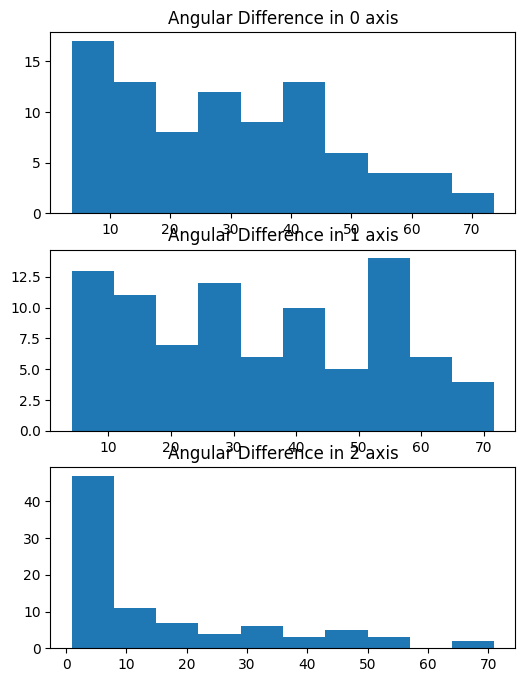

In [22]:
diffs_at_Reff = np.array(diffs_at_Reff)
#histogram of diffs_at_Reff
fig, ax = plt.subplots(3,1,figsize=(6,8))
for i in range(3):
    ax[i].hist(diffs_at_Reff[:,i],bins=10)
    ax[i].set_title(f'Angular Difference in {i} axis')
    #print count less than 10
    print(np.sum(diffs_at_Reff[:,i]<30))

In [ ]:
#test
def euler_to_rotation_matrix(phi, theta, psi):
    """ Converts Euler angles (in degrees) to a rotation matrix. """
    phi, theta, psi = np.deg2rad([phi, theta, psi])
    return R.from_euler('XYZ', [phi, theta, psi], degrees=False).as_matrix()

def generate_perturbed_orientations(base_orientations, num_samples=10, perturbation_range=1):
    """ Generate perturbed orientations around base orientations """
    np.random.seed(0)
    perturbed_orientations = []
    for base in base_orientations:
        for _ in range(num_samples):
            perturbed = base + np.random.uniform(-perturbation_range, perturbation_range, size=3)
            perturbed_orientations.append(perturbed)
    return np.array(perturbed_orientations)

# Base orientations with flips

xaxis_flip = R.from_matrix(np.array(([0,1,0],[-1,0,0],[0,0,1])))
print(xaxis_flip.as_euler('XYZ')*180/np.pi)




base_orientations = np.array([
    (180, 0, 0),
    (0, 0,0 ),
    #(180, 0, -180),
    (0, 0, 180)
])

# Generate perturbed orientations
perturbed_orientations = generate_perturbed_orientations(base_orientations, num_samples=25)

# Create rotation matrices for each perturbed orientation
rotation_matrices = np.array([euler_to_rotation_matrix(*ori) for ori in perturbed_orientations])

# Function to convert rotation matrices to Euler angles and adjust them
def rotation_matrices_to_euler(rot_matrices):
    euler_angles = np.array([R.from_matrix(matrix).as_euler('XYZ', degrees=True) for matrix in rot_matrices])
    return euler_angles

# Convert rotation matrices back to Euler angles
euler_angles = rotation_matrices_to_euler(rotation_matrices)


# Test plotting function
rbins = np.linspace(0, 1, len(perturbed_orientations))  # radius bins
plot_euler_angles(euler_angles,euler_angles, rbins, 'Simulation1', 'None', 1, 0.5)

In [70]:

I = np.identity(3)

print(np.linalg.det(I) , np.linalg.det(np.array(([0,1,0],[1,0,0],[0,0,1]))))


1.0 -1.0


In [ ]:


def plot_euler_angles(euler_Es, euler_Ed, rbins, sim, feedback, hid,Reff):
    fig, ax = plt.subplots(1,1,figsize=(6,2))
    ax.set_xlim([0,max(rbins)])
    
    Es_spline = None
    Ed_spline = None
    # Adjust the 0th Euler angles for symmetry about 90 degrees
    euler_Es[:, 0] = adjust_euler_angles(euler_Es[:, 0])
    euler_Ed[:, 0] = adjust_euler_angles(euler_Ed[:, 0])
    #plot raw data
    ax.plot(rbins, euler_Es[:, 0], label='Stellar: Phi', color='red')
    ax.plot(rbins, euler_Ed[:, 0], label='Dark Matter: Phi', color='black')

    spline_order = 3
    smoothing_factor = None

    Es_spline = scipy.interpolate.CubicSpline(rbins, euler_Es[:, 0], bc_type='natural')
    Ed_spline = scipy.interpolate.CubicSpline(rbins, euler_Ed[:, 0], bc_type='natural')
    
    #Es_spline = scipy.interpolate.UnivariateSpline(rbins, euler_Es[:,0])
    #Ed_spline = scipy.interpolate.UnivariateSpline(rbins, euler_Ed[:,0])
    sf = 500
    Es_spline.set_smoothing_factor(sf)
    Ed_spline.set_smoothing_factor(sf)

    #plot smoothed data

    evulate = np.linspace(np.min(rbins),np.max(rbins),100)
    ax.plot(evulate, Es_spline(evulate), color='red', ls = '--')
    ax.plot(evulate, Ed_spline(evulate), label='Smoothed', color='black',ls = '--')

    ax.axvline(Reff, color='black', alpha=0.5, label='R$_{eff}$')
    ax.grid(True)
    plt.xlabel('Radius Bins')
    plt.ylabel('Euler Angles (Phi)')
    plt.title(f'Euler Angles for Simulation: {sim}, Feedback: {feedback}, Halo ID: {hid}')
    plt.legend()
    plt.show()
def plot_euler_angles_on_sphere(euler_angles, rbins,sim,feedback,hid):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="k",alpha = .1)

    # Convert Euler angles to unit vectors
    unit_vectors = R.from_euler('XYZ', euler_angles, degrees=True).apply([1, 0, 0])

    # Extract x, y, z coordinates
    x, y, z = unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2]

    # Scatter plot on the sphere using rbins for color
    scatter = ax.scatter(x, y, z, c=rbins, cmap='viridis', label='Euler Angles')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Euler Angles on a Sphere')

    # Colorbar
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label('Radial Bins')

    # Set equal scaling and limits to make it spherical
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    plt.legend()
    plt.savefig(f'../../Figures/3DShapes/Orientations/{sim}.{feedback}.{hid}.png')
    #plt.close()